### LIBRARIES, MODULES, CONSTANTS

In [44]:
import os
import pandas as pd
from datetime import datetime
import seaborn as sns

### DATA LOAD

In [96]:
filename = 'CMBD_6_20181217-135856.xlsx'
path = os.path.join('..', 'data', 'external', filename)

raw_df = pd.read_excel(path)

In [97]:
raw_df.head(10)

,Año,Hospital Recodificado,Comunidad Autónoma,Provincia,Grupo Hospital,Grupo Cluster,Historia Recodificada,CIP Recodificado,Fecha de nacimiento,Sexo,...,GDR APR,CDM APR,Tipo GDR APR,Valor Peso Americano APR,Nivel Severidad,Nivel Mortalidad,Servicio,Edad,Reingreso,Coste
0,2013,-398345888794880068,13,28,4,4,-1687781257578748014,-320943158-171303395,10041944,1,...,194,5,M,1.0551,3,2,NML,69,1,4441.45
1,2013,-3959599681650518086,13,28,3,4,166370745435838543,648485069584850511,10061937,1,...,140,4,M,0.9057,3,3,NML,75,0,4550.50
2,2013,-3959599681650518086,13,28,3,4,183632305468848809,899288196-1988273609,14111923,1,...,194,5,M,2.2623,4,4,NML,90,0,4441.45
3,2013,-1468647043-245326524,13,28,4,5,2877111881585847151,-961279109-1723117644,10051956,2,...,194,5,M,1.0551,3,4,NML,56,0,4441.45
4,2013,946141513-1168024764,13,28,3,3,17519509571482774643,-33451060035352825,7091928,1,...,136,4,M,0.8844,2,2,NML,84,0,4761.87
5,2013,-1471938236-1755285183,13,28,3,3,5445333511499705976,-946716980449311376,19031934,1,...,194,5,M,1.0551,3,3,NML,79,1,4441.45
6,2013,-397825696459335749,13,28,3,4,-1879040836-1872569987,-990568731-2089071272,29051928,1,...,194,5,M,1.0551,3,2,NML,84,1,4441.45
7,2013,946141513-1168024764,13,28,3,3,981393224-1385903294,-2015593280-807416164,12031938,1,...,194,5,M,1.0551,3,3,NML,75,0,4441.45
8,2013,-1472122499828415297,13,28,2,3,-177819578578752866,13066340391778236408,15101961,2,...,134,4,M,0.9479,2,1,NML,51,0,4292.98
9,2013,-1203390089-1184784059,13,28,2,2,11654035061585015160,-2120889145-186808970,19041959,1,...,136,4,M,0.6490,1,1,NML,54,0,4761.87


### DATA WRANGLING

In [105]:
def str_date(int_date):
    """
    Converts an integer representing a date in DDMMYYYY format to datetime YYYYMMDD.
    It takes into account that if day < 0, there won't be a padding 0 in the integer.
    
    30102013 -> 2013-10-30
     7022013 -> 2013-02-07
    """
    
    str_date = str(int_date)
    yyyymmdd_str =  str_date[-4:] + str_date[-6:-4] + str_date[:-6].zfill(2)
    return yyyymmdd_str

def parse_date(df, col):
    df[col + ' new'] = pd.to_datetime(df[col].map(str_date), format='%Y%m%d', errors = 'coerce')

date_cols = ['Fecha de ingreso', 'Fecha de alta']
keep_cols = ['Sexo','Edad','Diagnóstico Principal']

for col in date_cols:
    parse_date(raw_df, col)

hospitalizations_df = raw_df[keep_cols].copy()


for col in date_cols:
    hospitalizations_df[col] = raw_df[col + ' new'].copy()

In [106]:
hospitalizations_df.head()

,Sexo,Edad,Diagnóstico Principal,Fecha de ingreso,Fecha de alta
0,1,69,428.0,2013-10-30,2013-11-13
1,1,75,491.21,2013-03-19,2013-03-25
2,1,90,428.0,2013-11-15,2013-11-26
3,2,56,428.1,2013-04-28,2013-05-14
4,1,84,162.5,2013-02-07,2013-02-08


In [107]:
raw_df.head()

,Año,Hospital Recodificado,Comunidad Autónoma,Provincia,Grupo Hospital,Grupo Cluster,Historia Recodificada,CIP Recodificado,Fecha de nacimiento,Sexo,...,Tipo GDR APR,Valor Peso Americano APR,Nivel Severidad,Nivel Mortalidad,Servicio,Edad,Reingreso,Coste,Fecha de ingreso new,Fecha de alta new
0,2013,-398345888794880068,13,28,4,4,-1687781257578748014,-320943158-171303395,10041944,1,...,M,1.0551,3,2,NML,69,1,4441.45,2013-10-30,2013-11-13
1,2013,-3959599681650518086,13,28,3,4,166370745435838543,648485069584850511,10061937,1,...,M,0.9057,3,3,NML,75,0,4550.50,2013-03-19,2013-03-25
2,2013,-3959599681650518086,13,28,3,4,183632305468848809,899288196-1988273609,14111923,1,...,M,2.2623,4,4,NML,90,0,4441.45,2013-11-15,2013-11-26
3,2013,-1468647043-245326524,13,28,4,5,2877111881585847151,-961279109-1723117644,10051956,2,...,M,1.0551,3,4,NML,56,0,4441.45,2013-04-28,2013-05-14
4,2013,946141513-1168024764,13,28,3,3,17519509571482774643,-33451060035352825,7091928,1,...,M,0.8844,2,2,NML,84,0,4761.87,2013-02-07,2013-02-08


### EDA

In [140]:
hospitalizations_by_day_df = hospitalizations_df.groupby(['Fecha de ingreso']).size().reset_index(name='counts')


<AxesSubplot:xlabel='Fecha de ingreso', ylabel='counts'>

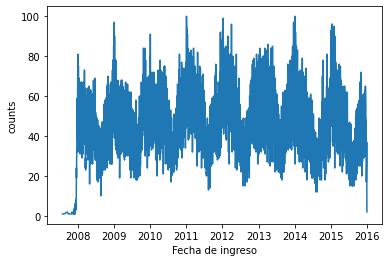

In [146]:
sns.lineplot(x = hospitalizations_by_day_df['Fecha de ingreso'], y= hospitalizations_by_day_df['counts'])